In [1]:
import torch
import os
import glob
import numpy as np
import random
import torchvision

path ='D:\\数据库\\dog_vs_cat'

# 猫狗数据分装

In [2]:
# files=glob(os.path.join(path,'*/*.jpg'))  #一共有25000个样本
# print(f'total number of images {len(files)}')
# num_of_images=len(files)

# #创建可用于创建验证集的混合索引
# shuffle=np.random.permutation(num_of_images)  #返回25000个0~25000内的无序排列数字

# #创建验证集目录
# os.mkdir(os.path.join(path,'valid'))

# #使用标签名创建目录
# for t in ['train','vaild']:
#     for folder in ['dog/','cat/']:
#         os.mkdir(os.path.join(path,t,folder))
        
# #将图片的2000张复制到验证集目录
# for i in shuffle[:2000]:
#     folder=files[i].split('/')[-1].split('.')[0]
#     image=files[i].split('/')[-1]
#     os.rename(files[i],os.path.join(path,'valid',folder,image))

# #将图片的剩余部分复制到训练集目录
# for i in shuffle[2000:]:
#     folder=files[i].split('/')[-1].split('.')[0]
#     image=files[i].split('/')[-1]
#     os.rename(files[i],os.path.join(path,'train',folder,image))

# 数据加载到pytorch张量

In [3]:
from torchvision.datasets import ImageFolder  #用于加载自己数据集的图片及标签
from torchvision import transforms

simaple_transforms=transforms.Compose([transforms.Scale((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

train=ImageFolder(os.path.join(path,'train/'),simaple_transforms)
valid=ImageFolder(os.path.join(path,'valid/'),simaple_transforms)

print(train.class_to_idx)
print(train.classes)

D:\anconda\envs\pyenv\lib\site-packages\torchvision\transforms\transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


{'cat': 0, 'dog': 1}
['cat', 'dog']


# 可视化张量

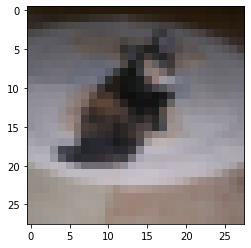

In [4]:
import matplotlib.pyplot as plt

def imshow(inp):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([[0.485,0.456,0.406]])
    std=np.array([0.229,0.224,0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    
imshow(train[50][0])

torch.Size([28, 28, 3])

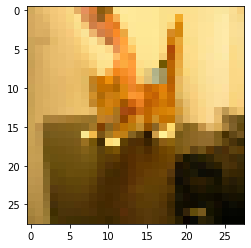

In [5]:
# 或者
from PIL import Image
cat=np.array(Image.open('D:\\数据库\\dog_vs_cat\\train\\cat\\cat.0.jpg').resize((28,28)))
plt.imshow(cat)

cat_tensor=torch.from_numpy(cat)
cat_tensor.size()  #torch.Size([224, 224, 3])

# 按批加载pytorch张量

In [6]:
from torch.utils.data import DataLoader

train_loader=DataLoader(train,batch_size=64,num_workers=0)
valid_loader=DataLoader(valid,batch_size=64,num_workers=0)

# 构造网络——用resnet

In [7]:
from torchvision import models
import torch.nn as nn

model_res18=models.resnet18(pretrained=True)
num_in=model_res18.fc.in_features
model_res18.fc=nn.Linear(num_in,2)

is_cuda=True
if is_cuda:
    model_res18=model_res18.cuda()

In [8]:
print(model_res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# 定义损失和优化器

In [9]:
lr=0.001
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_res18.parameters(),lr=lr,momentum=0.9)
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

# 训练模型

In [10]:
import time
from torch.autograd import Variablec

def train_model(model,loss_fn,optimizer,scheduler,num_epochs=10):
    since=time.time()
    
    best_model=model.state_dict()
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        #每轮都有训练和验证阶段
        for phase in ['train','valid']:
            if phase =='train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
                
            running_loss=0.0
            running_corrects=0
            
            #在批数据上迭代
            for data in dataloaders[phase]:
                inputs,labels=data
                
                if is_cuda:
                    inputs=Variable(inputs.cuda())
                    labels=Variable(labels.cuda())
                else:
                    inputs,labels=Variable(inputs),Variable(labels)
                    
                optimizer.zero_grad()
                    
                outputs=model(inputs)
                #print(outputs.shape) # ([64, 2])
                #print(labels.shape)  #([64])
                _,preds=torch.max(outputs.data,1)
                loss=loss_fn(outputs,labels)
                    
                #只在训练阶段反传
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                        
                #统计一个epoch内的平均损失和准去率
                running_loss+=loss.data
                running_corrects+=torch.sum(preds==labels.data)
                    
            epoch_loss=running_loss/datasets_sizes[phase]
            epoch_acc=running_corrects/datasets_sizes[phase]
                
            print('{} Loss: {:.4f} Acc: {:4f}'.format(phase,epoch_loss,epoch_acc))
                
            #深度复制模型
            if phase=='valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model=model.state_dict()
            
        print()
        
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
        
    #加载最优权重
    model.load_state_dict(best_model)
    return model               

dataloaders={'train':train_loader,'valid':valid_loader}
datasets_sizes={'train':23000,'valid':2000}
train_model(model_res18,loss,optimizer,lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0024 Acc: 0.000000
valid Loss: 0.7054 Acc: 1.000000

Epoch 1/9
----------
train Loss: 0.0212 Acc: 0.000000
valid Loss: 0.2890 Acc: 1.000000

Epoch 2/9
----------
train Loss: 0.0123 Acc: 0.000000
valid Loss: 0.3003 Acc: 1.000000

Epoch 3/9
----------
train Loss: 0.0102 Acc: 0.000000
valid Loss: 0.3930 Acc: 1.000000

Epoch 4/9
----------
train Loss: 0.0095 Acc: 0.000000
valid Loss: 0.3749 Acc: 1.000000

Epoch 5/9
----------
train Loss: 0.0093 Acc: 0.000000
valid Loss: 0.4318 Acc: 1.000000

Epoch 6/9
----------
train Loss: 0.0090 Acc: 0.000000
valid Loss: 0.4048 Acc: 1.000000

Epoch 7/9
----------
train Loss: 0.0271 Acc: 0.000000
valid Loss: 0.0914 Acc: 1.000000

Epoch 8/9
----------
train Loss: 0.0099 Acc: 0.000000
valid Loss: 0.0930 Acc: 1.000000

Epoch 9/9
----------
train Loss: 0.0098 Acc: 0.000000
valid Loss: 0.0948 Acc: 1.000000

Training complete in 27m 21s
Best val Acc: 1.0000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# 定义训练模型函数

In [11]:
def fit(epoch,model,data_loader,phase='training',volatile=False,dataset_size=23000):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss=0.0
    running_correct=0
    for batch_idx,(data,target) in enumerate(data_loader):
        if is_cuda:
            data,target=data.cuda(),target.cuda()
        data,target=Variable(data,volatile),Variable(target)
        
        if phase =='training':
            optimizer.zero_grad()
            
        output=model(data)
        loss=loss_fn(output,target)
        running_loss+=loss_fn(output,target).data
        preds=output.data.max(dim=1,keepdim=True)[1]
        running_correct+=preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
            
    loss=running_loss/dataset_size
    accuracy=100.*running_correct/dataset_size
    print(f'{phase} loss is {loss} and {phase} accuracy is {running_correct}/{dataset_size}{accuracy}')
    return loss,accuracy

# 训练模型2

training loss is 0.0006130184629000723 and training accuracy is 19815/2300086
validation loss is 0.3922363817691803 and validation accuracy is 2543/2000127
training loss is 0.002619796432554722 and training accuracy is 19632/2300085
validation loss is 0.23124898970127106 and validation accuracy is 2543/2000127
training loss is 0.0017433970933780074 and training accuracy is 19581/2300085
validation loss is 0.17548798024654388 and validation accuracy is 2543/2000127
training loss is 0.0014647713396698236 and training accuracy is 19519/2300084
validation loss is 0.18927402794361115 and validation accuracy is 2543/2000127
training loss is 0.0013293836964294314 and training accuracy is 19558/2300085
validation loss is 0.20355547964572906 and validation accuracy is 2543/2000127
training loss is 0.0011485761497169733 and training accuracy is 19598/2300085
validation loss is 0.22277384996414185 and validation accuracy is 2543/2000127
training loss is 0.0010058097541332245 and training accuracy

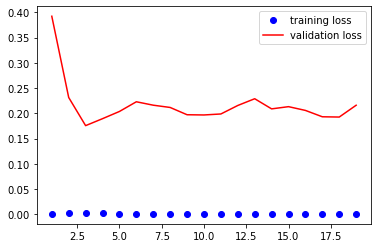

In [12]:
model=models.resnet18(pretrained=True)
num_in=model.fc.in_features
model.fc=nn.Linear(num_in,2)
loss_fn=nn.CrossEntropyLoss()

is_cuda=True
if is_cuda:
    model=model.cuda()

optimizer=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
train_losses,train_accuracy=[],[]
val_losses,val_accuracy=[],[]
for epoch in range(1,20):
    epoch_loss,epoch_accuracy=fit(epoch,model,train_loader,phase='training',dataset_size=23000)
    val_epoch_loss,val_epoch_accuracy=fit(epoch,model,valid_loader,phase='validation',dataset_size=2000)
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label='training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label='validation loss')
plt.legend()
    

In [ ]:
# 可视化中间层的输出